## An Introduction to Bayesian Statistics and Approximate Bayesian Computing 


Samuel Wiqvist, Ph.D. student, Lund University.

Twitter: @samuel_wiqvist

Homepage: http://www.maths.lu.se/staff/samuel-wiqvist/



In [35]:
# load packages and set up
using PyPlot
using Distributions
using Printf
using Random 
using KernelDensity

# data model
Random.seed!(12)
α = 2; β = 2
m = 4; n = 10; p_true = 0.7
y_obs = rand(Binomial(m,p_true),n) # generate data

# analytical posterior
posterior = Beta(α + sum(y_obs), β + m*n - sum(y_obs));

# plot function
function plot_abc_inference_results(abc_posterior_samples)
    
    kde_approx_posterior = kde(abc_posterior_samples)

    # plot results
    PyPlot.figure(figsize=(7,4))
    PyPlot.plot(kde_approx_posterior.x,kde_approx_posterior.density, "b")
    PyPlot.plot(0:0.01:1,pdf.(posterior, 0:0.01:1), "r")
    PyPlot.plot(0:0.01:1, pdf.(prior, 0:0.01:1), "g")
    PyPlot.plot((p_true, p_true), (0, maximum(pdf.(posterior, 0:0.01:1))), "k")
    PyPlot.xlabel("p")
    PyPlot.ylabel("Density")
    PyPlot.legend(["ABC posterior"; "Analytical posterior"; "Prior"; "Ground truth"])

end 

plot_abc_inference_results (generic function with 1 method)

#### What we will talk about today

* Introduction to Bayesian statistics.
    * Simple example: Bayesian linear regression.

* Introduction to ABC.
    * We will have a practical focus and run ABC for a simple model (the Beta-Binomial model).   


* ABC and deep learning:
    * Learning summary statistics using deep learning;
    * Other network-based approaches.

* Conclusion:
    * Something on the computer exercise.

#### The Bayesian statistical model 1/2
 
$$
p(\theta | y) = \frac{p(y | \theta) p(\theta)}{p(y)} = \frac{p(y | \theta) p(\theta)}{\int_{}^{} p(y | \theta) p(\theta) d\theta}.
$$

$p(\theta)$ - prior

$p(y|\theta)$ - likelihood

$p(\theta|y)$ - posterior

#### The Bayesian statistical model 1/2

* The normalizing constant $\int_{}^{} p(y | \theta) p(\theta) d\theta$ is usually hard to compute, but up to proportionality we have that 

$$
p(\theta | y) \propto p(y | \theta) p(\theta).
$$

* This property if of importance since many inference methods only require us to be ablet o evaluate the posterior up to a normalizing constant.

#### The Bayesian inference method 

* The goal is to compute (or sample from) the posterior distribution $p(\theta|y)$.  

* Sampling methods (Markov Chain Monte Carlo methods) are popular.

* But there are other inference methods as well, e.g. Maximum a posterior (MAP) estimation and variational inference.

#### How the Bayesian framework differs for the frequentist framework

* The Bayesian framework utilizes a subjective probability interpretation, while the frequentists framework utilizes a frequentistic probability interpretation.

* The subjective probability interpretation is how we use "probability" in everyday language, and can also be considered to non-repetitive events.

* In the Bayesian framework, unknown parameters $\theta$ are random variables, while in the frequentists framework the unknown parameters $\theta$  are unknown *fixed* constants. 

#### Example: Bayesian linear regression for the cars-dataset 1/5

* Toy example: Linear regression for the cars data set (stopping distance for 1920's cars).

<img src="fig/cars_data.svg" width="800" height="800" align = "bottom"/>


#### Example: Bayesian linear regression for the cars-dataset 2/5

* The model 

$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i, \, \epsilon_i \sim \mathcal{N}(0, \sigma),$$
$$\beta_0, \beta_1 \sim \mathcal{N}0, 10),$$
$$\sigma \sim \text{Gamma}(2,3).$$

#### Example: Bayesian linear regression for the cars-dataset 3/5

* Do the priors make sens (prior predictive analyses)?
* Prior predictive distribution: $p(\tilde{y}) = \int p(\tilde{y}|\theta) p(\theta) d\theta$.

<img src="fig/prior_predictions1.svg" width="600" height="600" align = "bottom"/>
* Conclusion: The priors are (very) weakly informative. 

#### Example: Bayesian linear regression for the cars-dataset 4/5

* Inference results and comparison with maximum likelihood (least squares).

|                           | <font size="5">Maximum likelihood (LS)</font>   | <font size="5">Bayesian inference (MCMC)</font>                  | 
|---------------------------|----------------------|-----------------------|
| <font size="5">$\beta_0$</font>                  |<font size="5">-17.58 (-31.17, -3.99)</font> |<font size="5">-11.18 (-22.40, 0.99)</font>   |
| <font size="5">$\beta_1$</font>                  |<font size="5">3.93 (3.10, 4.77)</font>      |<font size="5">3.56 (2.82, 4.28)</font>       |
| <font size="5">$\sigma$</font>                   |<font size="5">15.38 (12.83, 19.21)</font>   |<font size="5">15.23 (12.62, 18.59)</font>    |


#### Example: Bayesian linear regression for the cars-dataset 5/5
* Are the parameter estimations reliable (posterior predictive analyses)?
* Posterior predictive distribution:  $p(\tilde{y}|y_{\text{obs}}) = \int p(\tilde{y}|\theta, y_{\text{obs}}) p(\theta |y_{\text{obs}}) d\theta$.

<img src="fig/post_predictions.svg" width="600" height="600" align = "bottom"/>
* Conclusions: The parameter estimations are reliable since we can generate *fake* data from the posterior predictive distribution, that is similar to the observed data.

#### Approximate Bayesian Computation: Simulation based inference 

* ABC in a nut-shell: Simulations-based inference method where we generate parameter proposal $\theta^\star$ and accept $\theta^\star$ if the generated data $y^{\star}\sim p(y|\theta^\star)$ is *similar* to our observed data $y^{\text{obs}}$.

* ABC only requires that we can simulate data from a computer simulator of our model $p(y|\theta)$.

* Thus, ABC is very generic, and can be applied for models where the likelihood function is intractable.   

* *Curse-of-dimensionality*: Instead of comparing the data sets, we compare a set of summary statistics $s =S(y)$. For example, for dynamic models, summaries can be autocorrelations, cross-covariances, stationary mean. For i.i.d. data could be quantiles, mean, and standard deviation, etc.

#### Approximate Bayesian Computation: Rejection sampling method 

* Generate $\tilde{N}$ independent proposals $\theta^i\sim p(\theta)$,  and corresponding data sets  $y^i\sim p(y|\theta^i)$ from the computer simulator $p(y|\theta)$.

* Compute the summary statistics $s^i = S(y^i)$ for each $i=1,\ldots,\tilde{N}$.

* Compute the distances $\Delta(s^{i}, s^{\text{obs}})$ for each $i=1,\ldots,\tilde{N}$. 

* Retain proposals $\theta^i$ corresponding to those $\Delta(s^{i}, s^{\text{obs}})$ such that  $\Delta(s^{i}, s^{\text{obs}}) \leq \epsilon$, for some  $\epsilon \geq 0$.

#### How the ABC method works

* The algorithm generates samples from the joint distribution $p^{\epsilon}_{\text{ABC}}(\theta^{\star},s^{\star} | s^{\text{obs}}) \propto\mathcal{1}(\Delta(s^{\star}, s^{\text{obs}}) \leq \epsilon)p(s^{\star}|\theta)p(\theta) = (s^{\star}_{1:\tilde{M}}, \theta^{\star}_{1:\tilde{M}})$.

* However we are interested in $p^{\epsilon}_{\text{ABC}}(\theta^{\star} | s^{\text{obs}}) \propto \int p^{\epsilon}_{\text{ABC}}(\theta^{\star},s^{\star} | s^{\text{obs}})ds^{\star}$.

* Thus we simply take the joint disbution $p^{\epsilon}_{\text{ABC}}(\theta^{\star},s^{\star} | s^{\text{obs}}) \propto\mathcal{1}(\Delta(s^{\star}, s^{\text{obs}}) \leq \epsilon)p(s^{\star}|\theta)p(\theta) = (s^{\star}_{1:\tilde{M}}, \theta^{\star}_{1:\tilde{M}})$ and marginalizes over $s^{\star}$. Which in the Monte Calor scheme means only keeping the  $\theta^{\star}_{1:\tilde{M}}$ samples.  

#### ABC rejection sampling for the Beta-Binomial model

Model: $$y \sim \text{Binomial}(m,p),$$ $$p \sim \text{Beta}(\alpha, \beta).$$ 


In [91]:
# Define the model and the prior distribution.

m = 4; p_true = 0.7; # model parameters 

n = 10; # number of samples from the model 

data_generator(p) = rand(Binomial(m,p),n) # define the data generating function

Random.seed!(12) # fix random numbers 
y_obs = data_generator(p_true) # generate data

# prior 
α = 2; β = 2
prior = Beta(α,β);

#### ABC rejection sampling for the Beta-Binomial model 

In [92]:
# define the summary statistics 
S_handpicked(y) = sum(y); # canonical statistic, i.e. the statistic is sufficient!

In [93]:
# ABC rejection sampling algorithm 
function abc_rs(;N_proposals::Int, ϵ::Real, S::Function)
    
    abc_posterior_samples = zeros(N_proposals) 
    nbr_accepted_proposals = 0 
    
    s_obs = S(y_obs) # compute summary statistics for obs. data 
    
    for i in 1:N_proposals
    
        p_star = rand(prior) # sample parameter proposal from prior 
        y_star = data_generator(p_star) # generate data from the computer simulator 
        Δ =  abs(S(y_star)-s_obs) # compute ABC distance      
        
        if Δ <= ϵ # accapte proposal 
            nbr_accepted_proposals += 1 
            abc_posterior_samples[nbr_accepted_proposals] = p_star 
        end 
        
    end 
    
    return abc_posterior_samples[1:nbr_accepted_proposals]
end; 

#### ABC rejection sampling for the Beta-Binomial model

In [98]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs(N_proposals = 10^6, ϵ  = 3., S=S_handpicked);
@printf "Acceptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Acceptance rate: 21.18 %

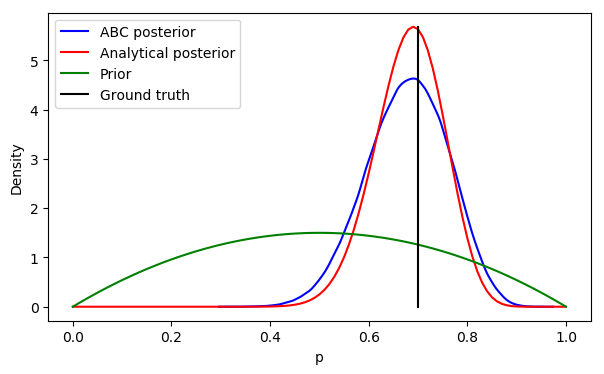

In [99]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### More advanced methods

* The ABC rejection-sampling algorithm is *very* inefficient (since we sample proposals from the prior).

* Thus, in practice more efficient algorithms are used (e.g. ABC-MCMC, ABC-SMC, or my personal favorite ABC-PMC).

#### Learning summary statistics for ABC using deep learning 1/x

#### How to select/learn summary statistics

* The summary statistics *should* be low-dimensional and informative for the parameters (in the ideal case sufficient).

* The problem of selecting informative summary statistics is the main challenge when applying ABC in practice;

* Usually, summary statistics are ad-hoc and "handpicked" out of subject-domain expertise. For example, for dynamic models, summaries can be autocorrelations, cross-covariances, stationary mean. For i.i.d. data could be quantiles, mean, and standard deviation, etc..

* Several methods to learn/select summary statistics have been developed (see (Prangle, 2015) for a review on these methods);

#### Learning summary statistics for ABC using deep learning 1/x

* An important paper is Fearnhead & Prangle, 2012 where they use linear regression to learn summary statistics, they also show that the posterior mean is the *best* (in terms of loss for the posterior mean) summary statistic; 

* The semi-automatic ABC method (Fearnhead & Prangle, 2012):
    * We can sample a set of parameter-data pairs $(\theta^{i}, y^i)_{1 \leq i \leq N}$, by sampling $\theta^{i}$ from the prior $p(\theta)$, and then simulate corresponding data set $y^{i}$ from the simulator $p(y|\theta)$;    
    * Learn the posterior mean from the $N$ simulations,  using a linear regression model: $$\theta_j^i = E(\theta_j | y^i) + \xi_j^i = b_{0_j} + b_j h(y^i) + \xi_j^i.$$
    * After fitting the linear regression model $S_j(y^{\star}) = \tilde{b}_{0_j} + \tilde{b}_j h(y^{\star})$ is the j:th summary statistics for the proposed data set $y^{\star}$. 

#### Learning summary statistics for ABC using deep learning 1/x

##### Semi-automatic ABC for the Beta-Binomial model: Step 1: Generate data

In [100]:
# generate parameter-data pairs  
N = 1000
parameters = rand(prior, N)
data = zeros(N,10)
for i in 1:N; data[i,:] = data_generator(parameters[i]); end

#### Learning summary statistics for ABC using deep learning 1/x

##### Semi-automatic ABC for the Beta-Binomial model: Step 2: Fit linear regression model

In [101]:
# Fit linear regression model 
β = (data'*data)\data'*parameters; # ls estimation 

In [102]:
# Define the new function to compute the summary statistic 
S_semi_auto(y) = y'*β;

#### Learning summary statistics for ABC using deep learning 1/x

##### Semi-automatic ABC for the Beta-Binomial model: Step 2: Run ABC algorithm

In [103]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs(N_proposals = 10^6, ϵ  = 0.02, S=S_semi_auto);
@printf "Acceptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Acceptance rate: 5.19 %

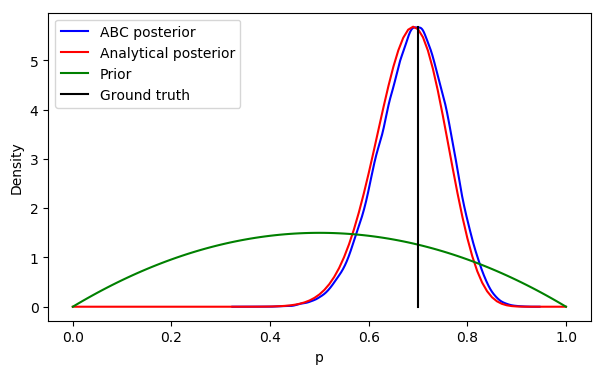

In [104]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### Learning summary statistics for ABC using deep learning 1/x

##### Replacing linear regression with multilayer perceptron (MLP) network


* In Jiang et al., 2017 they replace the linear regression model with a MLP network, thus they have following regression model: $$\theta^i = E(\theta|y^i) + \xi^i = f_{\beta}(y^i) + \xi^i.$$
    Where $f_{\beta}$ is the MLP parameterized by the weights $\beta$.


<img src="fig/dnn_structure.PNG" width="800" height="800" align = "bottom"/>

Source: (Jiang et al., 2017).

#### Learning summary statistics for ABC using deep learning 1/x

##### Partially exchangeable networks (PENs) (Wiqvist et al., 2019)

* Markovian data is *partially exchangeable* (which is a property that characterizes Markovian data the same way as *exchangeability* characterizes i.i.d. data). 

* Now, PEN is designed such that it is invariant to the partial exchangeability property of Markovian data.

* We can write the PEN regression model as: $$\theta^i = E(\theta|y^i) + \xi^i = \rho_{\beta_{\rho}}\biggl(y^i_{1:d}, \sum_{l = 1}^{M-d}  \phi_{\beta_{\phi}}(y^i_{l:l+d})\biggr) + \xi^i.$$   

* The advantage of PEN is that the architecture leverages the partial exchangeability property of Markovian data, and thus PEN does not have to *learn* this property.

#### Learning summary statistics for ABC using deep learning 1/x

##### Results for the AR2 model

Model: $$y_l = \theta_1 y_{l-1} + \theta_2 y_{l-2} + z_l,\qquad z_l \sim N(0,1).$$

<img src="fig/ar2_10_6.svg" width="10000" height="10000" align = "bottom"/>

#### Learning summary statistics for ABC using deep learning 1/x

##### Results for the AR2 model

Model: $$y_l = \theta_1 y_{l-1} + \theta_2 y_{l-2} + z_l,\qquad z_l \sim N(0,1).$$

<img src="fig/ar2_10_5.svg"  width="10000" height="10000" align = "bottom"/>

#### Learning summary statistics for ABC using deep learning 1/x

##### Results for the AR2 model

Model: $$y_l = \theta_1 y_{l-1} + \theta_2 y_{l-2} + z_l,\qquad z_l \sim N(0,1).$$

<img src="fig/ar2_10_4.svg"  width="10000" height="10000" align = "bottom"/>

#### Learning summary statistics for ABC using deep learning 1/x

##### Results for the AR2 model

Model: $$y_l = \theta_1 y_{l-1} + \theta_2 y_{l-2} + z_l,\qquad z_l \sim N(0,1).$$

<img src="fig/ar2_10_3.svg"  width="10000" height="10000" align = "bottom"/>

#### Deep learning based methods 1/2 

* Sequential neural density estimation - does not requre us to select ABC-threashold, learns a proposal distribution *automatically* (see for instance Papamakarios & Murray, 2016)

* Automatic Posterior Transformation - a version of SNDE (Greenberg et al., 2019)

#### Deep learning based methods 2/2 

<img src="fig/atp_fig.png"  width="500" height="500" align = "bottom"/>

Source: (Greenberg et al., 2019).

#### Conclusions 

* A short hands-on introduction to Bayesian statistics and the workflow for Bayesian analyses.  

* A short hands-on introduction to approximate Bayesian computation.  

* How we can use deep learning to learn summary statistics for ABC.

* Some other deep learning-based methods that are similar to ABC.

* Computer exercise: Implement the ABC rejection sampling algorithm for the g-and-k distribution.

#### Thank you for listening!

Homepage: http://www.maths.lu.se/staff/samuel-wiqvist/

Github: SamuelWiqvist

Twitter: samuel_wiqvist

#### References 

Fearnhead,  P.  and  Prangle,  D. *Constructing summary statistics for approximate bayesian computation:  semi-automatic approximate Bayesian computation*. Journal of the Royal Statistical Society: Series B, 74(3):419–474, 2012.

Greenberg, David S., Marcel Nonnenmacher, and Jakob H. Macke. "Automatic Posterior Transformation for Likelihood-Free Inference." arXiv preprint arXiv:1905.07488 (2019).

Jiang, B., Wu, T.-y., Zheng, C., and Wong, W. H. *Learning summary statistic for approximate Bayesian computation via deep neural network*. Statistica Sinica, pp. 1595–1618, 2017.

Papamakarios, George, and Iain Murray. "Fast ε-free inference of simulation models with Bayesian conditional density estimation." Advances in Neural Information Processing Systems. 2016.

Prangle, D. *Summary statistics in approximate Bayesian computation*. arXiv:1512.05633, 2015.

Wiqvist, S., Mattei P-A., Picchini U., and Frellsen J. *Partially Exchangeable Networks and Architectures for Learning Summary Statistics in Approximate Bayesian Computation*, arXiv:1901.10230, 2019. 

#### Extra slide: ABC rejection sampling for the Beta-Binomial model  

In [12]:
# ABC rejection sampling algorithm 
function abc_rs_without_summary_stats(;N_proposals::Int, ϵ::Real)
    
    abc_posterior_samples = zeros(N_proposals)
    nbr_accepted_proposals = 0 
    
    for i in 1:N_proposals
    
        p_star = rand(prior) # sample parameter proposal from prior 
        y_star = data_generator(p_star) # generate data from the data model
        Δ = sum(abs.(sort(y_star)-sort(y_obs))) # compute ABC distance      
        
        if Δ <= ϵ # accept proposal 
            nbr_accepted_proposals += 1 
            abc_posterior_samples[nbr_accepted_proposals] = p_star 
        end 
    end 
    
    return abc_posterior_samples[1:nbr_accepted_proposals]
end; 

#### Extra slide: ABC rejection sampling for the Beta-Binomial model 

In [13]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs_without_summary_stats(N_proposals = 10^6, ϵ  = 0);
@printf "Acceptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Acceptance rate: 0.35 %

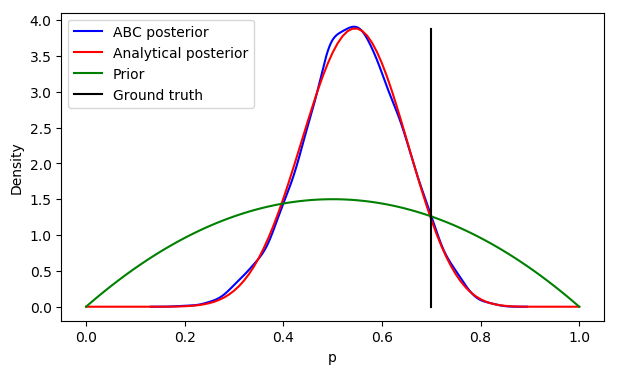

In [14]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### Extra slide: Approximate Bayesian Computation: Approximate posterior 

* The joint distribution of accapted parameter-data paris $(\theta^{\star}, s^{\star})$ is 
$$p(\theta^{\star}, s^{\star}) = p(s^{\star}|\theta^{\star}) p(\theta^{\star}) I(\Delta(s^{\star},s^{\text{obs}}) \leq \epsilon),$$
where $s^{\text{obs}} = S(y^{\text{obs}})$, $I$ indicator kernel, $\Delta$ distance function, and $\epsilon$ the threshold.



* Now assume that $S(s^{\star}) = S(s^{\text{obs}}) \,\, \text{iff} \,\, y^{\star} = y^{\text{obs}}$ and let $\epsilon = 0$. Now marginlizing $s^{\star}$ yields the true posterior:
$$ p(\theta^{\star}| s^{\text{obs}}) = \int p(s^{\star}|\theta^{\star}) p(\theta^{\star}) I(\Delta(s^{\star},s^{\text{obs}}) \leq \epsilon)   ds^{\star} = p(y |\theta^{\star}) p(\theta^{\star}) \propto  p(\theta^{\star}| y) .$$

* However, in (almost) all situations we sample from an approximate posterior: 

$$p^{\epsilon}_{\text{ABC}}(\theta^{\star} | s^{\text{obs}}) \propto \int p(s^{\star}|\theta^{\star}) p(\theta^{\star}) I(\Delta(s^{\star},s^{\text{obs}}) \leq \epsilon)   ds^{\star}.$$


#### Extra slide: Results for the AR2 model with observation noise

Model: $$y_l = \theta_1 y_{l-1} + \theta_2 y_{l-2} + z_l,\qquad z_l \sim N(0,1).$$

<img src="fig/res_ar2_wasserstein.svg" width="800" height="2000" align="center"/>

#### Extra slide: Results for the MA2 model with observation noise

Model: $$y_i = x_i + e_i, \qquad e_i \sim N(0, \sigma_\epsilon),$$ $$x_i = z_i + \theta_1 z_{i-1} + \theta_2 z_{i-2}, \qquad z_i \sim N(0, 1).$$


<img src="fig/res_ma2_wasserstein.svg" width="800" height="2000" align="center"/>
